<a href="https://colab.research.google.com/github/tobby-lie/Recurrent-Neural-Network-from-Scratch/blob/master/Lie_5931_PA3_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import csv
import itertools
import operator
import numpy as np
import sys
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
plt.style.use('seaborn-white')

%cd /content/drive/My\ Drive/5931_PA3
%ls

/content/drive/My Drive/5931_PA3
Lie_5931_PA3_Task2.ipynb  Lie_5931_PA3_Task4.ipynb
Lie_5931_PA3_Task3.ipynb  SciFi_Three.txt


In [0]:
import matplotlib.pyplot as plt

def generate_loss_epoch_plt(losses):
  ''' generates loss vs epoch plot based off of list of losses generted from training'''
  x_plt = []  # holds x values
  y_plt = []  # holds y values

  epoch_ct = 0  # need epoch_ct to keep track of which epoch the loss belongs to
  # for each loss add the epoch and appropriate loss from tuple to x and y
  for loss in losses:
    x_plt.append(epoch_ct)
    y_plt.append(loss[1])
    epoch_ct += 1

  plt.plot(x_plt, y_plt)  # plot from x and y lists
  plt.title('Loss vs. Epoch') # title 
  plt.ylabel('Loss') # y axis title
  plt.xlabel('Epoch') # x axis title
  plt.show() 

In [0]:
data = open('SciFi_Three.txt', 'r').read()

In [0]:
#Process data and calculate indexes
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 2442629 characters, 100 unique


In [0]:
data_size

2442629

In [0]:
X_size

100

In [0]:
# Constants and hyper-params
H_size = 100 # Size of the hidden layer
T_steps = 12 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [0]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [0]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [0]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

### Forward Backward Pass

In [0]:
# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

In [0]:
# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [0]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

# Generate next character

In [0]:
def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

# Training

In [0]:
# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [0]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [0]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

# Training loop

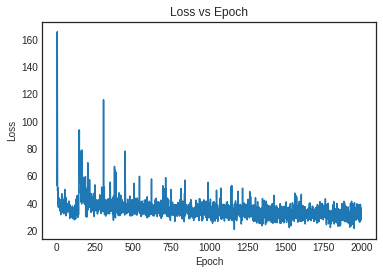

----
   hif,l,y rig tdte lad ita ue dl thdo
routt vnygtot
d ifkd t bed he b ong aeofithenps, oi9onte tin besgboadoverd tiggrm mei b. bve winsis 
 nw t agacer tertdttois anligiwdan in
d d g pfmbdt ve nta vig 
----
iter 2000, loss 36.894896
(2000, 32.941934961703424)


In [0]:
count = 0
iter_loss= []
iters = 2001

while count < iters:

  if pointer + T_steps >= len(data) or iteration == 0:
    g_h_prev = np.zeros((H_size, 1))
    g_C_prev = np.zeros((H_size, 1))
    pointer = 0


  inputs = ([char_to_idx[ch.lower()] 
              for ch in data[pointer: pointer + T_steps]])
  targets = ([char_to_idx[ch.lower()] 
              for ch in data[pointer + 1: pointer + T_steps + 1]])

  loss, g_h_prev, g_C_prev = \
      forward_backward(inputs, targets, g_h_prev, g_C_prev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001

  if iteration % 40 == 0:
    update_status(inputs, g_h_prev, g_C_prev)

  update_paramters()

  plot_iter = np.append(plot_iter, [iteration])
  plot_loss = np.append(plot_loss, [loss])

  print((iteration,loss))

  pointer += T_steps
  iteration += 1
  count += 1

### Gradient Check

Approximate the numerical gradients by changing parameters and running the model. Check if the approximated gradients are equal to the computed analytical gradients (by backpropagation).

Try this on `num_checks` individual paramters picked randomly for each weight matrix and bias vector.

In [0]:
from random import uniform

# Calculate numerical gradient
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

In [0]:
# Check gradient of each paramter matrix/vector at `num_checks` individual values
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
   
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [0]:
gradient_check(4, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_o (-9.038104e-07, -9.036690e-07) => 7.814302e-05
W_o (9.769963e-09, 9.693982e-09) => 3.712885e-03
W_o (4.060041e-06, 4.060072e-06) => 3.799890e-06
W_v (1.128146e-05, 1.128131e-05) => 6.633902e-06
W_v (9.760193e-06, 9.760554e-06) => 1.852438e-05
W_v (1.013252e-05, 1.013226e-05) => 1.271070e-05
b_o (-2.182077e-06, -2.182098e-06) => 4.767633e-06
b_o (-4.423129e-08, -4.410811e-08) => 1.378715e-03
b_o (4.875034e-06, 4.874788e-06) => 2.521147e-05
b_v (1.191012e-05, 1.190983e-05) => 1.204112e-05
